In [174]:
from joblib import dump, load
import numpy as np
import pickle
import pandas as pd
import matplotlib.pyplot as plt
import deap
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import roc_auc_score

In [175]:
class DynamicFuzzySystem:
    def __init__(self,
                 output_membership_functions,
                 predictors):
        # create empty data frame for the membership values that stay fixed because we fix the mfs
        self.membership_value_pd = pd.DataFrame(columns=predictors)
        self.membership_func_names_pd = pd.DataFrame(columns=predictors)
        self.output_membership_functions = output_membership_functions

    @staticmethod
    def defuzz_center_of_sums(y, output_shape):
        """ Defuzzification using the center of area
            CONFIRMED, see: https://codecrucks.com/defuzzification-methods-solved-examples/"""
        left = output_shape[0]
        center = output_shape[1]
        right = output_shape[2]
        area = .5 * (right - left)
        # scale the output membership function using rule weight
        scaled_function = center * y * area
        return scaled_function, area

    @staticmethod
    def memb_tri(x, triangle):
        """This function determines the membership value belonging to the user defined triangle
        INPUTS
        x - the value
        triangle - user defined triangle in order:left, center, right"""
        left = triangle[0]
        center = triangle[1]
        right = triangle[2]

        if left <= x < center:
            # Left side of triangle
            membership = (x - left) / (center - left)
        elif center <= x <= right:
            # Right side of triangle
            if (center - right) == 0:
                membership = 1
            else:
                membership = (x - right) / (center - right)
        else:
            # not in triangle
            membership = 0
        return membership

    def input_to_membership(self, input_name, input_column, membership_functions, membership_function_labels):
        """
        Calculates the membership values for all membership functions for all data points for a certain input

        This function takes the parameters:
        input_name - name of input as listed in data
        input_column - the values of each data point for this input
        membership_functions - list of lists the holds the membership function info [[left, center, right], ...]
        membership_function_labels - labels for each of the membership functions
        """
        all_input_data = []
        for input_value in input_column:
            memberships = []
            for membership_function in membership_functions:
                membership = self.memb_tri(input_value, membership_function)
                memberships.append(membership)
            all_input_data.append([memberships])
        self.membership_value_pd[input_name] = pd.DataFrame(all_input_data)
        self.membership_func_names_pd[input_name] = [membership_function_labels]
        print('Membership values calculated for input: ' + input_name)

        
    def input_to_membership_intermediate_level(self, input_value, membership_functions):
        """
        Calculates the membership values for all membership functions for all data points for a certain input

        This function takes the parameters:
        input_value - the value of an input
        membership_functions - list of lists the holds the membership function info [[left, center, right], ...]
        """
        memberships = []
        for membership_function in membership_functions:
            membership = self.memb_tri(input_value, membership_function)
            memberships.append(membership)

        return memberships
        
        
    @staticmethod
    def check_if_rule_fires(memberships):
        # If each membership value in a rule is 0, then those membership functions do not fire together for this data
        # point
        memberships = np.array(memberships)
        is_all_zero = np.all((memberships == 0))
        return is_all_zero
    

    def rules2_1(self, input_1_mfs, input_2_mfs):
        """
        Calculate and rules for a two input one output FIS for one data point

        data_point - index of the current data point being calculated for
        """
        and_rules = []
        rule_number = 0
        non_fire_rules = []
        for mem_1 in input_1_mfs:
            for mem_2 in input_2_mfs:
                and_rules.append(min(mem_1, mem_2))
                if self.check_if_rule_fires([mem_1, mem_2]):
                    non_fire_rules.append(rule_number)
                    
                rule_number += 1
        return and_rules, non_fire_rules



    def rules3_1(self, input_1_mfs, input_2_mfs, input_3_mfs):
        """
        Calculate and rules for a three input one output FIS for one data point

        """
        and_rules = []
        rule_number = 0
        non_fire_rules = []
        for mem_1 in input_1_mfs:
            for mem_2 in input_2_mfs:
                for mem_3 in input_3_mfs:
                    and_rules.append(min(mem_1, mem_2, mem_3))
                    if self.check_if_rule_fires([mem_1, mem_2, mem_3]):
                        non_fire_rules.append(rule_number)
                        
                    rule_number += 1
        return and_rules, non_fire_rules
    
    
    def rules4_1(self, input_1_mfs, input_2_mfs, input_3_mfs, input_4_mfs):
        """
        Calculate and rules for a four input one output FIS for one data point

        data_point - index of the current data point being calculated for
        """
        and_rules = []
        rule_number = 0
        non_fire_rules = []
        for mem_1 in input_1_mfs:
            for mem_2 in input_2_mfs:
                for mem_3 in input_3_mfs:
                    for mem_4 in input_4_mfs:
                        and_rules.append(min(mem_1, mem_2, mem_3, mem_4))
                        if self.check_if_rule_fires([mem_1, mem_2, mem_3, mem_4]):
                            non_fire_rules.append(rule_number)
                        rule_number += 1
                        
        return and_rules, non_fire_rules


    def defuzzification(self, and_rules, map_to_output_func, alternate_output_functions=[]):
        """
        defuzzification of the system to get final crisp output

        and_rules - result of the and rules
        map_to_output_func - GA determines which output function this rule maps to

        """
        output_membership_funcs = self.output_membership_functions
        if alternate_output_functions:
            output_membership_funcs = alternate_output_functions
        lam_numerator = 0
        lam_denominator = 0
        for and_rule, map_to_output_func in zip(and_rules, map_to_output_func):
            # Defuzzification using the center of sums
            if map_to_output_func > (len(output_membership_funcs)-1):
                map_to_output_func = len(output_membership_funcs)-1
            if and_rule != 0:
                output_value = self.defuzz_center_of_sums(and_rule, output_membership_funcs[int(map_to_output_func)])
                lam_numerator += output_value[0]
                lam_denominator += output_value[1]

        # Check to make sure denominator is not 0
        if lam_denominator == 0:
            lam = 0
        else:
            lam = lam_numerator / lam_denominator

        # return the output of this fis
        return lam

In [176]:
def layers_of_fis(data_point, ga_vec):    
    # Output of first layer
    lam_propulsion_power = fis_class.defuzzification(and_rules_values_pd["propulsion_power"][data_point], ga_vec[0:96])
    lam_propulsion_age = fis_class.defuzzification(and_rules_values_pd["propulsion_age"][data_point], ga_vec[96:132])
    lam_carrying_capacity = fis_class.defuzzification(and_rules_values_pd["carrying_capacity"][data_point], ga_vec[132:180])
    lam_length = fis_class.defuzzification(and_rules_values_pd["length"][data_point], ga_vec[180:189])


    # SIZE FIS - intermediate
    fixed_rules_3_1 =   [0.0, 0.0, 1.0,
                         0.0, 1.0, 2.0,
                         1.0, 2.0, 2.0,

                         0.0, 1.0, 2.0,
                         1.0, 2.0, 2.0,
                         2.0, 2.0, 3.0,

                         1.0, 2.0, 2.0,
                         2.0, 2.0, 3.0,
                         2.0, 3.0, 3.0]
    
    # SIZE FIS - intermediate######
    carrying_capacity_mems = fis_class.input_to_membership_intermediate_level(lam_carrying_capacity, mfs_fixed_3_1)
    length_mems = fis_class.input_to_membership_intermediate_level(lam_length, mfs_fixed_3_1)
    size_and_rules, s_non_fire = fis_class.rules3_1(fis_class.membership_value_pd["GSS_Gross.tonnage"][data_point],
                                                    carrying_capacity_mems,
                                                    length_mems)
    # output of intermediate FIS size
    lam_size = fis_class.defuzzification(size_and_rules, fixed_rules_3_1, alternate_output_functions=mfs_fixed_3_1)

    # PROPUSION FIS - intermediate
    fixed_rules_2_1 = [0, 0, 1,
                       0, 1, 2,
                       1, 2, 2]
    propulsion_power_mems = fis_class.input_to_membership_intermediate_level(lam_propulsion_power, mfs_fixed)
    propulsion_age_mems = fis_class.input_to_membership_intermediate_level(lam_propulsion_age, mfs_fixed)
    propulsion_and_rules, p_non_fire = fis_class.rules2_1(propulsion_power_mems, propulsion_age_mems)
    # output of intermediate FIS propulsion
    lam_propulsion = fis_class.defuzzification(propulsion_and_rules, fixed_rules_2_1)


    # Membership calulations for final FIS
    size_mems = fis_class.input_to_membership_intermediate_level(lam_size, mfs_fixed)
    propulsion_mems = fis_class.input_to_membership_intermediate_level(lam_propulsion, mfs_fixed)
    final_and_rules, final_non_fire = fis_class.rules4_1(fis_class.membership_value_pd["GSS_Type_numeric"][data_point],
                                                         fis_class.membership_value_pd["age_in_months"][data_point],
                                                         size_mems, propulsion_mems)
    lam_final = fis_class.defuzzification(final_and_rules, ga_vec[189:432])
    return lam_final


In [177]:
def classify_points(test_data, test_data_y, chromosome, fit_function_fis):
    """
    Returns
    -------
    total error and the
    the confusion matrix for the points

    """
    def round_to_output(value):
        check_1 = abs(1-value)
        check_0 = abs(0-value)
        if check_1 < check_0:
            rounded_value = 1
        else:
            rounded_value = 0
        return rounded_value
    
    predicted_values = []
    # Initialize confusion matrix
    confusion_matrix = np.zeros((2, 2))
    error = 0
    for ordered_data_row, actual_label in zip(np.arange(0, len(test_data_y)), test_data_y):
        predicted_value = fit_function_fis(ordered_data_row, np.floor(chromosome))
        predicted_values.append(predicted_value)

        # Fill in the confusion matrix
        classified_label = round_to_output(predicted_value)
        confusion_matrix[int(actual_label)][int(classified_label)] += 1
        # Get the error for each point
        error += abs(actual_label - predicted_value)

    return error, confusion_matrix, predicted_values

In [178]:
def calcs(c_matrix):
    Tp = c_matrix[1][1]
    Tn = c_matrix[0][0]
    Fp = c_matrix[1][0]
    Fn = c_matrix[0][1]
    accuracy = (Tp + Tn)/(Tp + Tn + Fp + Fn)
    sensitivity = Tp/(Tp + Fn)
    specificity = Tn/(Tn + Fp)
    return round(accuracy*100, 2), round(sensitivity*100, 2), round(specificity*100, 2)

In [179]:
# Mfs for output and fixed intermediate layers
mfs_fixed = [[0, 0, .4], [.2, .5, .8], [.6, 1, 1]]
mfs_fixed_3_1 = [[0, 0, .3], [.2, .35, .55], [.45, .65, .8], [.7, 1, 1]]

In [180]:
# Define the Input Membership Functions
# GSS_Type_numeric
mfs_predictor0 = [[-.1, 0, .1], [0.9, 1, 1.1], [1.9, 2, 2.1], [2.9, 3, 3.1], [3.9, 4, 4.1], [4.9, 5, 5.1], [5.9, 6, 6.1], [6.9, 7, 7.1], [7.9, 8, 8.1]]
membership_function_labels0 = ['type 0', 'type 1', 'type 2', 'type 3', 'type 4', 'type 5', 'type 6', 'type 7', 'type 8']

# "GSS_Propulsion_numeric"
mfs_predictor1 = [[-.1, 0, .1], [0.9, 1, 1.1], [1.9, 2, 2.1], [2.9, 3, 3.1]]
membership_function_labels1 = ['type 0', 'type 1', 'type 2', 'type 3']

# "GSS_Main.engines..Model_numeric"
mfs_predictor2 = [[0, 150, 250], [170, 233, 400], [300, 400, 670]]
membership_function_labels2 = ['young parts', 'middle age parts', 'old parts']

# "GSS_Main.engines..Designer_numeric",
mfs_predictor3 = [[130, 350, 375], [365, 420, 455], [445, 465, 505], [500, 545, 655]]
membership_function_labels3 = ['young parts', 'middle young parts', 'middle old parts', 'old parts']

# "GSS_Main.engines..Builder.code_numeric"
mfs_predictor4 = [[80, 220, 300], [280, 335, 400], [390, 440, 655]]
membership_function_labels4 = ['young parts', 'middle age parts', 'old parts']
    
# "GSS_Gross.tonnage"
mfs_predictor5 = [[0, 0, 50000], [45000, 60000, 125000], [120000, 140000, 175000]]
membership_function_labels5 = ['small', 'medium', 'large']

# "GSS_Deadweight"
mfs_predictor6 = [[0, 0, 50000], [45000, 60000, 125000], [120000, 170000, 330000]]
membership_function_labels6 = ['small', 'medium', 'large']
    
# "GSS_TEU"
mfs_predictor7 = [[-1.1, -1, -.9], [0, 0, 2500], [2200, 4000, 7600], [7400, 13000, 18000]]
membership_function_labels7 = ['no data', 'small', 'medium', 'large']
    
# "GSS_Insulated.capacity"
mfs_predictor8 = [[-1.1, -1, -.9], [0, 0, 1000], [800, 5000, 10000], [9000, 15000, 22000]]
membership_function_labels8 = ['no data', 'small', 'medium', 'large']
    
# "GSS_Length.overall"
mfs_predictor9 = [[40, 80, 150], [140, 180, 230], [220, 280, 400]]
membership_function_labels9 = ['small', 'medium', 'large']

# "GSS_Length.between.perpendiculars"
mfs_predictor10 = [[40, 75, 150], [130, 165, 230], [220, 280, 380]]
membership_function_labels10 = ['small', 'medium', 'large']
    
# "GSS_Service.speed"
mfs_predictor11 = [[-1.1, -1, -.9], [0, 10, 12], [11, 13.5, 20], [18, 24, 28]]
membership_function_labels11 = ['no data', 'small', 'medium', 'large']

# "GSS_Main.engines..Number.of.main.engines"
mfs_predictor12 = [[0, 1, 1.8], [1.5, 3, 6]]
membership_function_labels12 = ['small', 'large']

# "GSS_Main.engines..Max..power"
mfs_predictor13 = [[0, 0, 20000], [18000, 40000, 60000], [50000, 68000, 81000]]
membership_function_labels13 = ['small', 'medium', 'large']

# "age_in_months"
mfs_predictor14 = [[40, 130, 200], [180, 210, 380], [360, 400, 670]]
membership_function_labels14 = ['young', 'middle age', 'old']

all_membership_functions = [mfs_predictor0, mfs_predictor1, mfs_predictor2, mfs_predictor3, mfs_predictor4,
                            mfs_predictor5, mfs_predictor6, mfs_predictor7, mfs_predictor8, mfs_predictor9,
                            mfs_predictor10, mfs_predictor11, mfs_predictor12, mfs_predictor13, mfs_predictor14]

all_membership_function_labels = [membership_function_labels0, membership_function_labels1, membership_function_labels2, membership_function_labels3, membership_function_labels4,
                                  membership_function_labels5, membership_function_labels6, membership_function_labels7, membership_function_labels8, membership_function_labels9,
                                  membership_function_labels10, membership_function_labels11, membership_function_labels12, membership_function_labels13, membership_function_labels14]

In [181]:
# Predictors after coversions
predictors_final = ["GSS_Type_numeric",
                  "GSS_Propulsion_numeric",
                  "GSS_Main.engines..Model",
                  "GSS_Main.engines..Designer",
                  "GSS_Main.engines..Builder.code",
                  "GSS_Gross.tonnage",
                  "GSS_Deadweight",
                  "GSS_TEU",
                  "GSS_Insulated.capacity",
                  "GSS_Length.overall",
                  "GSS_Length.between.perpendiculars",
                  "GSS_Service.speed",
                  "GSS_Main.engines..Number.of.main.engines",
                  "GSS_Main.engines..Max..power",
                  "age_in_months"]

In [182]:
# open a file, where you stored the pickled data
file = open('data_folds_7_11', 'rb')

# dump information to that file
df = pickle.load(file)

# close the file
file.close()

In [183]:
current_fold = 0
train_idxes = df['folds'][current_fold][0]
test_idxes = df['folds'][current_fold][1]

train_dataset_X = df['X'].loc[list(train_idxes), :]
train_dataset_Y = df['Y'].loc[list(train_idxes)]

test_dataset_X = df['X'].loc[list(test_idxes), :]
test_dataset_Y = df['Y'].loc[list(test_idxes)]

In [184]:
fis_class = DynamicFuzzySystem(mfs_fixed, predictors_final)
# Calcualte the membership values for the inputs - these will stay fixed because the membership functions stay fixed
for predictor_input, mfs_predictor, membership_function_labels in zip(predictors_final, all_membership_functions, all_membership_function_labels):
    fis_class.input_to_membership(predictor_input, train_dataset_X[predictor_input], mfs_predictor, membership_function_labels)

Membership values calculated for input: GSS_Type_numeric
Membership values calculated for input: GSS_Propulsion_numeric
Membership values calculated for input: GSS_Main.engines..Model
Membership values calculated for input: GSS_Main.engines..Designer
Membership values calculated for input: GSS_Main.engines..Builder.code
Membership values calculated for input: GSS_Gross.tonnage
Membership values calculated for input: GSS_Deadweight
Membership values calculated for input: GSS_TEU
Membership values calculated for input: GSS_Insulated.capacity
Membership values calculated for input: GSS_Length.overall
Membership values calculated for input: GSS_Length.between.perpendiculars
Membership values calculated for input: GSS_Service.speed
Membership values calculated for input: GSS_Main.engines..Number.of.main.engines
Membership values calculated for input: GSS_Main.engines..Max..power
Membership values calculated for input: age_in_months


In [185]:
### STRUCTURE CHANGE FROM JULY 12 
# Rule and aggregation calculations for fixed inputs - these will stay fixed so calculation occurs once here
and_rules_values_pd = pd.DataFrame(columns=["propulsion_power", "propulsion_age", "carrying_capacity", "length"])
non_fire_rules_values_pd = pd.DataFrame(columns=["propulsion_power", "propulsion_age", "carrying_capacity", "length"])

# the indexes in the membership_value_pd are corresponding to the length of the trianing dataset
# the indexes when accesing from the actual dataset are corresponding to which values were chosen in the 
for data_point in np.arange(0, len(train_dataset_X)):
    propulsion_power_and_rules, pp_non_fire = fis_class.rules4_1(fis_class.membership_value_pd["GSS_Propulsion_numeric"][data_point],
                                                                 fis_class.membership_value_pd["GSS_Main.engines..Number.of.main.engines"][data_point],
                                                                 fis_class.membership_value_pd["GSS_Main.engines..Max..power"][data_point],
                                                                 fis_class.membership_value_pd["GSS_Service.speed"][data_point])

    propulsion_age_and_rules, pa_non_fire = fis_class.rules3_1(fis_class.membership_value_pd["GSS_Main.engines..Model"][data_point],
                                                               fis_class.membership_value_pd["GSS_Main.engines..Designer"][data_point],
                                                               fis_class.membership_value_pd["GSS_Main.engines..Builder.code"][data_point])

    carrying_capacity_and_rules, cc_non_fire = fis_class.rules3_1(fis_class.membership_value_pd["GSS_Deadweight"][data_point],
                                                                  fis_class.membership_value_pd["GSS_TEU"][data_point],
                                                                  fis_class.membership_value_pd["GSS_Insulated.capacity"][data_point])

    length_and_rules, l_non_fire = fis_class.rules2_1(fis_class.membership_value_pd["GSS_Length.overall"][data_point],
                                                      fis_class.membership_value_pd["GSS_Length.between.perpendiculars"][data_point])
    
    and_rules_values_pd.loc[data_point] = [propulsion_power_and_rules, propulsion_age_and_rules, carrying_capacity_and_rules, length_and_rules]
    non_fire_rules_values_pd.loc[data_point] = [pp_non_fire, pa_non_fire, cc_non_fire, l_non_fire]


In [102]:
pp_non_fire

[16, 19, 20, 23, 40, 43, 44, 47, 88, 91, 92, 95]

In [103]:
pa_non_fire

[24, 26, 30, 32, 33, 35]

In [104]:
w_non_fire

[4, 5, 7, 8]

In [105]:
cc_non_fire

[1, 2, 3, 9, 10, 11, 13, 14, 15]

In [106]:
l_non_fire

[4, 5, 7, 8]

In [254]:
model_name = 'models/run_100gen40pop_05theta_my_calc'

In [255]:
# load a stored model
model = load(model_name + '.joblib')
error_over_time = model['Error over time'][0]
best_chromosome = model['Best Chromosome'][0]
# time_to_train = model['Time'][0]


In [257]:
error_test, confusion_matrix_test, predicted_values_test = classify_points(test_dataset_X, test_dataset_Y, best_chromosome, layers_of_fis)
confusion_matrix_test

array([[282.,  63.],
       [ 29.,   9.]])

In [258]:
error_train, confusion_matrix_train, predicted_values_train = classify_points(train_dataset_X, train_dataset_Y, best_chromosome, layers_of_fis)
confusion_matrix_train

array([[1295.,   85.],
       [  96.,   54.]])

In [266]:
accuracy, sensitivity, specificity = calcs(confusion_matrix_train)
print('accuracy: ', accuracy)
print('sensitivity: ', sensitivity)
print('specificity: ', specificity)

accuracy:  88.17
sensitivity:  38.85
specificity:  93.1


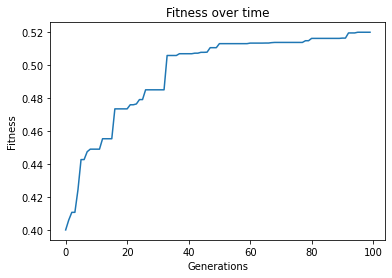

In [263]:
generations_array = np.arange(0, len(error_over_time), 1)
error_over_time_per_point = 1/error_over_time
plt.plot(generations_array, error_over_time_per_point)
plt.title('Fitness over time')
plt.xlabel('Generations')
plt.ylabel('Fitness', multialignment='center')
plt.show()

In [264]:
# create and plot precision-recall curve of the combined model
precision, recall, t = precision_recall_curve(y_true=train_dataset_Y,
                       probas_pred=predicted_values_train)
auc_score = roc_auc_score(train_dataset_Y, predicted_values_train)
auc_score

0.8099541062801933

Text(0.5, 1.0, 'Precision-Recall curve (combined model)')

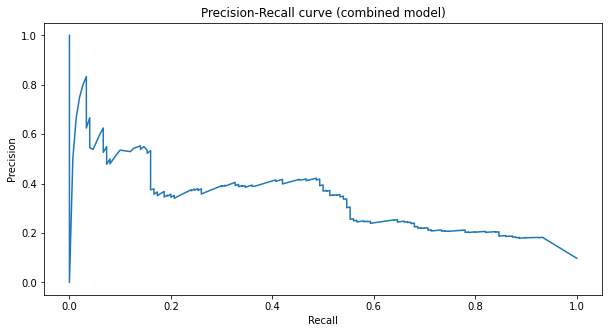

In [265]:
fig, ax = plt.subplots()
fig.set_size_inches((10, 5))
ax.plot(recall, precision)
ax.set_xlabel("Recall")
ax.set_ylabel("Precision")

ax.set_title("Precision-Recall curve (combined model)")

In [64]:
# model_deap = load('models/run5_5gen_20pop_deap.joblib')
# best_chromosome_deap = model_deap['Best Chromosome'][0]
# error_test_deap, confusion_matrix_test_deap = classify_points(test_dataset_X, test_dataset_Y, best_chromosome, layers_of_fis)